# ARMA Models

**Objective:** Fit and forecast ARMA models. Lab details are found at http://www.acme.byu.edu/wp-content/uploads/2018/03/ARMA.pdf.

In [1]:
import numpy as np
from scipy import linalg as la
import scipy
from scipy import stats
from scipy import optimize as opt
from matplotlib import pyplot as plt

In [2]:
time_series_a = np.loadtxt("time_series_a.txt")
time_series_b = np.loadtxt("time_series_b.txt")
time_series_c = np.loadtxt("time_series_c.txt")

**Problem 1:** Write a function that computes the log-liklihood of an ARMA $(p,q)$ model, given a time series $z_t.$

In [5]:
def arma_likelihood(time_series, phis=np.array([]), thetas=np.array([]), mu=0.,
         sigma=1.):
    """
     Return the log-likelihood of the ARMA model parameters, given the time
     series.
     Parameters
     ----------
     time_series : ndarray of shape (n,1)
         The time series in question, z_t
     phis : ndarray of shape (r,)
         The phi parameters
     thetas : ndarray of shape (q,)
         The theta parameters
     mu : float
         The parameter mu
     sigma : float
         The standard deviation of the a_t random variables
     Returns
     -------
     log_likelihood : float
         The log-likelihood of the model
     """
    p = len(phis)
    q = len(thetas)
    r = max(p, q+1)
    F = np.diag(np.ones(r-1), -1)
    F[0,:p] = phis
    d = time_series.ndim
    H = np.zeros((d, r))
    H[0, 0]  = 1
    H[0, 1:(q+1)] = thetas  
    Q = np.zeros((r, r))
    Q[0,0] = sigma**2

    #calculate initial x, p 
    #x1|0, P1|0 - reshape to rxr, flatten Q
    x = np.zeros(r)
    P = la.solve(np.eye(r**2, r**2) - np.kron(F,F), Q.flatten()).reshape((r,r))

    n = P.shape[0]
    obs = time_series - mu
       
    log_liklihood = 0
    
    for z in obs:
        # Update
        y = z - H@x
        S = H@P@H.T 
        K = la.solve(S.T, H@P.T).T
        mean = H@x
        log_liklihood += np.log(scipy.stats.norm.pdf(z, mean, np.sqrt(S)))
        # Update state estimate with new x
        x = x + K@y
        P = (np.eye(K.shape[0]) - K@H)@P
        
        # Predict
        x = F@x 
        P = F@P@F.T + Q
    return log_liklihood


In [6]:
log_lik = arma_likelihood(time_series_a, phis=np.array([0.9]), mu=17., sigma=0.4)
print("Log liklihood:",log_lik)

Log liklihood: [[-77.60354497]]


**Problem 2:** Write a function that accepts a time series ${z_t}$ and returns the parameters of the model that minimize the AIC, given the constraint that $p \leq 3, q \leq 3.$

In [7]:
 def arma_fit(time_series):
    """
    Return the ARMA model that minimizes AICc for the given time series,
    subject to p,q <= 3.
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
        The time series in question, z_t
    Returns
    -------
    phis : ndarray of shape (p,)
        The phi parameters
    thetas : ndarray of shape (q,)
        The theta parameters
    mu : float
        The parameter mu
    sigma : float
        The standard deviation of the a_t random variables
    """
    n = len(time_series)
    
    #aicc = lambda k,l, arma_liklihood: 2k(1+ (k+1)/(n-k) - 2arma_liklihood)
    aicc = lambda k, n, l: 2*k*(1 + (k+1)/(n-k)) - 2*l
    best_params = 0
    best_p = 0
    best_q = 0
    
    p_ls = [0,1,2,3]
    q_ls = [0,1,2,3]
    best_aicc = 9999
    #grid search along p's and q's - initial should be random guess of zeros
    for p in p_ls:
        for q in q_ls:
            x0 = np.zeros(p+q+2)
            x0[-2] = time_series.mean()
            x0[-1] = time_series.std()
            
            def f(x): # x contains the phis, thetas, mu, and sigma
                return -1*arma_likelihood(time_series, phis=x[:p], thetas=x[p:p+q], mu=x[-2],sigma=x[-1])

            #scipy.opt gerenates phis and thetas
            sol = opt.fmin(f, x0, maxiter=10000, maxfun=10000)
            if aicc(p+q+2, n, -f(sol)) < best_aicc:
                #save parameters
                best_params = sol
                best_p = p
                best_q = q
                best_aicc = aicc(p+q+2, n, -f(sol))[0][0]

    return best_params[:best_p], best_params[best_p:best_p+best_q], best_params[-2], best_params[-1]


**Problem 3:** Use your solution from Problem 2 to fit models to the data found in time_series_a.txt, time_series_b.txt, and time_series_c.txt. Report the fitted parameters $p, q, \theta.$

In [9]:
phis_a, thetas_a, mu_a, sigma_a = arma_fit(time_series_a)

In [37]:
print(phis_a, thetas_a, mu_a, sigma_a)

[ 0.90867024] [-0.57585945] 17.0652624863 0.312530986282


In [10]:
phis_b, thetas_b, mu_b, sigma_b = arma_fit(time_series_b)

In [39]:
print(phis_b, thetas_b, mu_b, sigma_b)

[ 0.2350456 -0.3839864 -0.6566961] [-0.20234983  0.41060419  0.67314649] -0.28538044042 7.03345253754


In [11]:
phis_c, thetas_c, mu_c, sigma_c = arma_fit(time_series_c)
print(phis_c, thetas_c, mu_c, sigma_c)

In [41]:
print(phis_c, thetas_c, mu_c, sigma_c)

[ 1.22481184 -0.56007884] [ 0.38466735] 48.4622781112 14.6225375589


**Problem 4:** Forecast each data set ahead 20 intervals using the parameters discovered from Problem 3, and plot their expected values along with the original data set. Also plot the expected values plus and minus $\sigma_{t+k}$, and plus and minus $2\sigma_{t+k}$ to demonstrate credible intervals.

In [112]:
def arma_forecast(time_series, phis=np.array([]), thetas=np.array([]), mu=0.,
        sigma=1., future_periods=20):
    """
    Return forecasts for a time series modeled with the given ARMA model.
    Parameters
    ----------
    time_series : ndarray of shape (n,1)
    The time series in question, z_t
    phis : ndarray of shape (p,)
        The phi parameters
    thetas : ndarray of shape (q,)
        The theta parameters
    mu : float
        The parameter mu
    sigma : float
        The standard deviation of the a_t random variables
    future_periods : int
        The number of future periods to return
    Returns
    -------
    e_vals : ndarray of shape (future_periods,)
        The expected values of z for times n+1, ..., n+future_periods
    sigs : ndarray of shape (future_periods,)
        The standard deviations of z for times n+1, ..., n+future_periods
    """
    #Find X_t, P_t with the same way as problem 1
    p = len(phis)
    q = len(thetas)
    r = max(p, q+1)
    F = np.diag(np.ones(r-1), -1)
    F[0,:p] = phis
    d = time_series.ndim
    H = np.zeros((d, r))
    H[0, 0]  = 1
    H[0, 1:(q+1)] = thetas  
    Q = np.zeros((r, r))
    Q[0,0] = sigma**2

    #calculate initial x, p 
    #x1|0, P1|0 - reshape to rxr, flatten Q
    x = np.zeros(r)
    P = la.solve(np.eye(r**2, r**2) - np.kron(F,F), Q.flatten()).reshape((r,r))

    n = P.shape[0]
    obs = time_series - 17.0652624863
       
    log_liklihood = 0
#     print(obs)
    for z in obs:
        # Update
        y = z - H@x
#         print(z)
        S = H@P@H.T 

        K = la.solve(S.T, H@P.T).T
#         print(K, y)
        #mean, var=S
        # Update state estimate with new x
        x = x + K@y
        P = (np.eye(K.shape[0]) - K@H)@P
        
        # Predict
        x = F@x 
        P = F@P@F.T + Q
    
    e_vals = []
    sigs = []
    #Predict future
    for t in range(future_periods):
        # Predict
        x = F@x 
        P = F@P@F.T + Q
        
        e_vals.append(H@x + mu)
        sigs.append(np.sqrt(H@P@H.T))
#         print(e_vals)
    return np.array(e_vals), np.array(sigs)

In [121]:
mu_1, sig_1 = arma_forecast(time_series_a, phis_a, thetas_a, mu_a, sigma_a, 4)

In [124]:
print("Test Case Expected Values:", mu_1," \n SD's:", sig_1)

Test Case Expected Values: [[ 17.3478036 ]
 [ 17.32199919]
 [ 17.29855149]
 [ 17.27724526]]  
 SD's: [[[ 0.32938498]]

 [[ 0.3426768 ]]

 [[ 0.35327487]]

 [[ 0.36179159]]]


In [125]:
mu_1a, sig_1a = arma_forecast(time_series_a, phis_a, thetas_a, mu_a, sigma_a, 20)

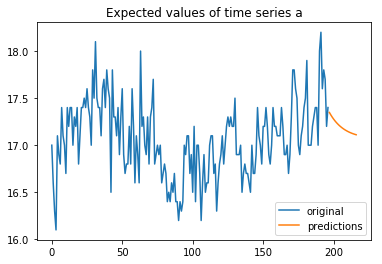

In [132]:
x1 = range(len(time_series_a))
x2 = range(len(time_series_a), 20 + len(time_series_a))
plt.plot(x1, time_series_a, label = "original")
plt.plot(x2, mu_1a, label = "predictions")
plt.title("Expected values of time series a")
plt.legend()
plt.show()

In [133]:
mu_b, sig_b = arma_forecast(time_series_b, phis_b, thetas_b, mu_b, sigma_b, 20)

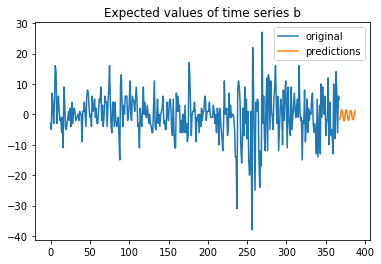

In [134]:
x1 = range(len(time_series_b))
x2 = range(len(time_series_b), 20 + len(time_series_b))
plt.plot(x1, time_series_b, label = "original")
plt.plot(x2, mu_b, label = "predictions")
plt.title("Expected values of time series b")
plt.legend()
plt.show()

In [137]:
mu_c, sig_c = arma_forecast(time_series_c, phis_c, thetas_c, mu_c, sigma_c, 20)

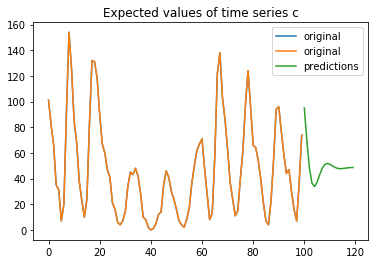

In [138]:
x1 = range(len(time_series_c))
x2 = range(len(time_series_c), 20 + len(time_series_c))
plt.plot(x1, time_series_c, label = "original")
plt.plot(x2, mu_c, label = "predictions")
plt.title("Expected values of time series c")
plt.legend()
plt.show()